
## Assignment 2 - MNIST classification

Train a convolutional neural network to predict the number of digits from MNIST Count dataset in three ways :

- Without training on the count dataset, but on the 28x28 dataset
- By training on the count dataset, while assessing number of layers, loss function, regularisation
- Using transfer learning, one time with weights randomly initialized and another time pretrained on the MNIST dataset. Compare acuraccies while using 20%, 50%, 100% of training data





## Method 1 - Sliding window
#### Without training on the count dataset, we will train the CNN on 28x28 and then continue on the test dataset.


In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
import numpy as np
from matplotlib import pyplot
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Defining training settings

In [2]:
kwargs={}

class Args():
  def __init__(self):
      self.batch_size = 500
      self.test_batch_size = 128
      self.epochs = 5
      self.lr = 0.005
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(30000 / self.batch_size)
      self.cuda = False

args = Args()

use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': False} if use_cuda else {}


### CNN arhitecture

The architecture of the model will be
  - conv layer: 20 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:1
  - conv layer: 50 filters, kernel size: 5x5, stride:1
  - relu
  - max pool: kernel size: 2x2, stride:1
  - fully connected: 500 neurons
  - relu
  - log softmax



1.   input : (batch_size, 28 x 28)
2.   output : 10 values - probabilities for every digit


In [ ]:
no_filters1 = 20
no_filters2 = 50
no_neurons1 = 500
class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(no_filters1, no_filters2, 5, 1)

        self.fc1 = nn.Linear(in_features = 4 * 4 * no_filters2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = 10)

    def forward(self, x):
      
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*no_filters2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


Loading MNIST dataset containing drawn digits with a total of 50k training samples and 10k testing samples. Each image has one channel and 28x28 pixels.

Loading pickle data for 100x100 classification


In [ ]:
!rm MNIST.tar.gz*
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz
!ls


--2021-04-01 18:06:34--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-04-01 18:06:34--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [        <=>         ]  33.20M  6.70MB/s    in 14s     

2021-04-01 18:06:48 (2.35 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

### Data loader for MNIST

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       
                   ])),
    batch_size=args.batch_size, shuffle=True,drop_last=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=args.test_batch_size, shuffle=False,drop_last=True, **kwargs)

first_train_batch_imgs, first_train_batch_labels = next(iter(train_loader))


### Training the CNN for MNIST classification.

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    
    model.train()
    all_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data, target.long()

        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        all_losses.append(loss.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    return np.array(all_losses).mean()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:
            data, target = data, target.long()
            output = model(data)
            
            test_loss += F.nll_loss(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).float().mean().item()
            num_iter += 1

    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter

    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy

### Optimizer and call the training / testing  functions.

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306841
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.069250

Test set: Average loss: 0.4764, Accuracy: (86%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.439727
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.326216

Test set: Average loss: 0.2507, Accuracy: (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.199198
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.248276

Test set: Average loss: 0.1842, Accuracy: (95%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.242898
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.170640

Test set: Average loss: 0.1391, Accuracy: (96%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.141205
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.125823

Test set: Average loss: 0.1173, Accuracy: (96%)

Model's state_dict:
conv1.weight 	 torch.Size([20, 1, 5, 5])
conv1.bias 	 torch.Size([20])
conv2.weight 	 torch.Size([50, 20, 5, 5])
conv2.bias 	 torch.Size([50])
fc1.weight 	 torch.Size([500, 800])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 t

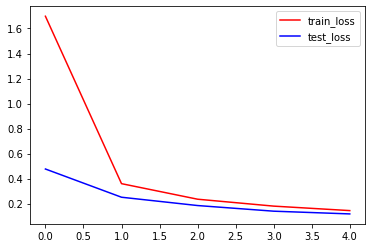

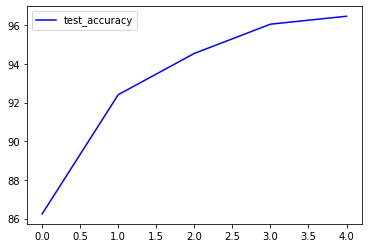

In [ ]:
model_mnist = CNN()
optimizer = optim.SGD(model_mnist.parameters(), lr=args.lr, momentum=args.momentum)

losses_train = []
losses_test = []
accuracy_test = []
for epoch in range(1, args.epochs + 1):
  
    train_loss = train(args, model_mnist, device, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test(args, model_mnist, device, test_loader)

    losses_train.append(train_loss)
    losses_test.append(test_loss)
    accuracy_test.append(test_accuracy)

def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()

pyplot.figure(1)
plot_loss(losses_train,'train_loss','red')
plot_loss(losses_test,'test_loss')
pyplot.figure(2)
plot_loss(accuracy_test,'test_accuracy')


path_to_pretrained = "mnist_cnn.pt"

print("Model's state_dict:")
for param_tensor in model_mnist.state_dict():
    print(param_tensor, "\t", model_mnist.state_dict()[param_tensor].size())

torch.save(model_mnist.state_dict(), path_to_pretrained)

### Sliding Window method

torch.Size([500, 1, 28, 28])
Labels of the shown images: tensor([6, 1, 4, 0, 7])
Predicted : 7
tensor(0.9997)
tensor([[1.4158e-07, 5.6912e-07, 6.4480e-05, 1.6712e-04, 2.3572e-08, 1.2275e-07,
         1.0397e-11, 9.9973e-01, 8.0135e-07, 3.8636e-05]])
tensor(1.)


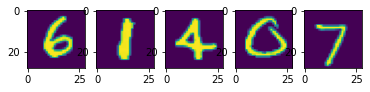

In [ ]:

print(first_train_batch_imgs.shape)

f, axarr = pyplot.subplots(1,5)
for i in range(5):
  axarr[i].imshow(first_train_batch_imgs[i,0])
print(f'Labels of the shown images: {first_train_batch_labels[:5]}')

with torch.no_grad() :

    output = np.e**model_mnist(first_train_batch_imgs[4].reshape(1, 1, 28, 28))
    print('Predicted : {}'.format(torch.argmax(output)))
    print(torch.max(output))
    print(output)
    print(torch.sum(output))
    
    
    axarr[i].imshow(first_train_batch_imgs[i,0])

### Data loader for MNIST, count dataset

In [8]:
import pickle

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


def get_large_dataset(path, max_batch_idx=100, shuffle=False, first_k=5000):

  with open(path,'rb') as handle:
    data = pickle.load(handle)

  np_dataset_large  = np.expand_dims(data['images'],1)[:first_k]
  np_dataset_no_count = data['no_count'].astype(np.float32)[:first_k]
  
  print(f'np_dataset_large shape: {np_dataset_large.shape}')
  
  dataset_large, dataset_no_count= map(torch.tensor, 
                (np_dataset_large, np_dataset_no_count))

  '''
  dataset_large = dataset_large.to(device)
  dataset_no_count = dataset_no_count.to(device)
  '''
  
  large_dataset = TensorDataset(dataset_large, dataset_no_count)
  large_data_loader = DataLoader(large_dataset, batch_size=args.batch_size, shuffle=shuffle, drop_last=True)
  
  return large_data_loader

path_train = 'gdrive/MyDrive/Adi/mnist_count_train.pickle'
path_test = 'gdrive/MyDrive/Adi/mnist_count_test.pickle'

large_data_loader_train = get_large_dataset(path_train, max_batch_idx=50,shuffle=True, first_k=5000)
large_data_loader_test = get_large_dataset(path_test, max_batch_idx=50)

np_dataset_large shape: (5000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)


We want to find the number of digits in the image by taking advantage of the previous trained network for classification of 28x28 MNIST digits. We will define a threshold after which we would predict the 28x28 is a digit.

We slide with 2 on the horizontal axis and 3 on the vertical axis of the 100 x 100 image in search for a 28x28 digit (so 72/2 * 72/3)


Results:

Threshold start point : 0.99

  - For 5 epochs train : 0.34 best
  - For 10 epochs train : 0.3 best
  - For more epochs, the model predicts hot-ones

The threshold grows adaptively from 0.99 with respect to acuraccy



In [ ]:
big_image_size = 100
small_image_size = 28

args.batch_size = 500
def predict_number_of_digits(batch, slidex = 2, slidey = 3):

  predicted_counts = torch.zeros(batch.shape[0])
 
  num_predictions = 0
  map = torch.zeros(batch.shape[0], 10)
 
  for i in range(0, big_image_size - small_image_size, slidex):
    for j in range(0, big_image_size - small_image_size, slidey):

        num_predictions += 1
        if num_predictions % 200 == 0:
            print("For this batch, {}th prediction".format(num_predictions))

        part = batch[:, :, i : i + small_image_size, j : j + small_image_size]
        part = part.float() / 255.0

        with torch.no_grad():  
           output = np.e**model_mnist(part.detach().cpu())

           pred = output.argmax(dim=1, keepdim=True)
            

           for k in range(0, batch.shape[0]):

              if output[k][pred[k]] >= threshold:
                  map[k][pred[k]] = 1
  
  for i in range(0, batch.shape[0]):
      for j in range(0, 10):
          if map[i][j] == 1:

             predicted_counts[i] += 1
             if predicted_counts[i] >= 5:
                  predicted_counts[i] = 5
  
  print("Next batch")

  return predicted_counts


correct = 0
total = 0
steps = 3
opt = 0.01
acuraccy = 0
threshold = 0.99
maximum_acuraccy = 0


while steps != 0:

  print("First batch:")
  for local_batch, local_labels in large_data_loader_test:

      local_batch, local_labels = local_batch, local_labels
      predicted_labels = predict_number_of_digits(local_batch.float())
      total += predicted_labels.shape[0]

      for i in range(predicted_labels.shape[0]):
          if predicted_labels[i] == local_labels[i]:
            correct += 1
  new_acuraccy = correct / total
  print("Acuraccy is : {}".format(new_acuraccy))

  if new_acuraccy > maximum_acuraccy :
    maximum_acuraccy = new_acuraccy

  opt /= 2
  print(opt)
  if new_acuraccy < acuraccy : 
      opt = -opt
  
  acuraccy = new_acuraccy
  threshold = threshold + opt
  steps -= 1

  print("New threshold is : {}".format(threshold))


print("Maximum acuraccy is : {}".format(maximum_acuraccy))




First batch:
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch
Acuraccy is : 0.335
0.005
New threshold is : 0.995
First batch:
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch
Acuraccy is : 0.327
0.0025
New threshold is : 0.9925
First batch:
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch
For this batch, 200th prediction
For this batch, 400th prediction
For this batch, 600th prediction
For this batch, 800th prediction
Next batch

## Method 2 - Convolutional neural network on MNIST - Count

Similar arhitecture, two convolutions and then three fully connected layers
Using Cross Entropy Loss for classification of five classes (1, 2, 3, 4 or 5 digits)

### Training settings for count dataset

In [5]:

class Args():
  def __init__(self):
      self.batch_size = 500
      self.test_batch_size = 500
      self.epochs = 20
      self.lr = 0.1
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = 4
      self.cuda = False


kwargs={}

args = Args()


### CNN arhitecture

In [12]:
no_filters1 = 20
no_filters2 = 50
no_neurons1 = 1024
no_neurons2 = 128

class CNN_count(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = no_filters1, kernel_size = 5, stride = 1)
        self.conv2 = nn.Conv2d(in_channels = no_filters1, out_channels = no_filters2, kernel_size = 5, stride = 1)
        
        self.fc1 = nn.Linear(in_features = 22 * 22 * no_filters2, out_features = no_neurons1)
        self.fc2 = nn.Linear(in_features = no_neurons1, out_features = no_neurons2)
        self.fc3 = nn.Linear(in_features = no_neurons2, out_features = 5)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 22 * 22 * no_filters2)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

### Training on count dataset, with and without regularisation

In [ ]:
def train_count(args, model, train_loader, optimizer, epoch):
        
        model.train()
        all_losses = []
        batch_id = 0
        criterion = nn.CrossEntropyLoss()
    
        print("Train starting...")
        for data, target in train_loader:
            batch_id += 1
    
            data, target = data.float() / 255.0, target.long() - 1
            
            optimizer.zero_grad()
                
            output = model(data)
    
            loss = criterion(output, target)
    
            all_losses.append(loss.detach().cpu().numpy())
            loss.backward()
    
            optimizer.step()
            
            if batch_id % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_id * len(data), len(train_loader.dataset),
                    100. * batch_id / len(train_loader), loss.item()))
                
        return np.array(all_losses).mean()
    
def test_count(args, model, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:

            data, target = data.float() / 255.0, target.long() - 1
            
            output = model(data)
            
            test_loss += criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).float().mean().item()

            num_iter += 1

    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter

    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy



def train_and_test(regularisation = False, decay = 0.001):

    acuraccies = []
    fractions = [0.2, 0.5, 1.0]

    for k in fractions:
        
        round_k = int(5000 * k)
        large_data_loader_train = get_large_dataset(path_train, max_batch_idx=50, shuffle=True, first_k=round_k)
        large_data_loader_test = get_large_dataset(path_test, max_batch_idx=50) 
       
        model = CNN_count()

        if regularisation == True: 
          optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum,weight_decay = decay)
        else:
          optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
          
        losses_train = []
        losses_test = []
        accuracy_test = []
        last_accuracy = 0
        
        for epoch in range(1, args.epochs + 1):
          
            train_loss = train_count(args, model, large_data_loader_train, optimizer, epoch)
        
            test_loss, test_accuracy = test_count(args, model, large_data_loader_test)
        
            losses_train.append(train_loss)
            losses_test.append(test_loss)
            accuracy_test.append(test_accuracy)
            last_accuracy = test_accuracy
        
        acuraccies.append(last_accuracy)
        
        def plot_loss(loss, label):
            pyplot.plot(loss, label=label)
            pyplot.legend()
        
        
        pyplot.figure(2)
        plot_loss(accuracy_test,'test_accuracy' + str(k))
            
    pyplot.figure(2)
    if regularisation == False:
      pyplot.title('MNIST Accuracies without regularisation')
    else:
      pyplot.title('MNIST Accuraccies with regularisation')
    print()
    pyplot.show()

    pl, ax = pyplot.subplots(1, 1)
    ax.plot(fractions, acuraccies, 'r-', lw=3, alpha=0.6, label='Acuraccy with respect to data usage')
    pyplot.show()
    print()


train_and_test(regularisation = False)
train_and_test(regularisation = True)




np_dataset_large shape: (1000, 1, 100, 100)
np_dataset_large shape: (1000, 1, 100, 100)
Train starting...

Test set: Average loss: 1.6104, Accuracy: (18%)

Train starting...

Test set: Average loss: 1.6089, Accuracy: (18%)

Train starting...

Test set: Average loss: 1.6067, Accuracy: (25%)

Train starting...

Test set: Average loss: 1.6037, Accuracy: (26%)

Train starting...

Test set: Average loss: 1.5974, Accuracy: (26%)

Train starting...

Test set: Average loss: 1.5858, Accuracy: (27%)

Train starting...

Test set: Average loss: 1.5594, Accuracy: (28%)

Train starting...

Test set: Average loss: 1.5654, Accuracy: (29%)

Train starting...

Test set: Average loss: 2.7308, Accuracy: (22%)

Train starting...

Test set: Average loss: 1.6184, Accuracy: (21%)

Train starting...

Test set: Average loss: 1.6130, Accuracy: (20%)

Train starting...

Test set: Average loss: 1.6121, Accuracy: (20%)

Train starting...

Test set: Average loss: 1.6120, Accuracy: (20%)

Train starting...

Test set:

## Transfer learning


In [ ]:
class Args():
  def __init__(self):
      self.batch_size = 500
      self.test_batch_size = 64
      self.epochs = 5
      self.lr = 0.001
      self.momentum = 0.9
      self.seed = 1
      self.log_interval = int(1000 / self.batch_size)
      self.cuda = False


kwargs={}

args = Args()
args.log_interval /= 10


In [ ]:
no_filters1 = 20
no_filters2 = 50
no_neurons1 = 500
no_features = 19 * 19 * 5

class CNN_pretrained(nn.Module):
  def __init__(self):

      super().__init__()
      self.conv1 = nn.Conv2d(1, no_filters1, 5, 1)
      
      self.conv2 = nn.Conv2d(no_filters1, no_filters2, 5, 1)
      
      self.fully_conv1  = nn.Conv2d(no_filters2, no_neurons1, 4)

      self.fully_conv2_new = nn.Conv2d(no_neurons1, 5, 1)
      
      self.linear_loc = nn.Linear(no_features, 1)

  def forward(self, xb):

      x = xb.view(-1, 1, xb.shape[2], xb.shape[3])
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.fully_conv1(x))
      
      self.conv_act = self.fully_conv2_new(x).view(args.batch_size,-1)

      self.lin = self.linear_loc(self.conv_act)
      self.final = F.relu(self.lin)
      return x


In [ ]:
model_pretrained = CNN_pretrained()
path_to_pretrained = 'mnist_cnn.pt'
loaded_state_dict = torch.load(path_to_pretrained)

model_dict = {}
for key,val in loaded_state_dict.items():
  
  key = key.replace('fc','fully_conv')

  print(f'key: {key}')

  if 'fully_conv1.weight' in key:
    val = val.view(-1,no_filters2, 4, 4)
  if 'fully_conv2.weight' in key:
    val = val.view(-1, no_neurons1, 1, 1)
  
  model_dict[key] = val
  

model_pretrained.load_state_dict(model_dict, strict=False)

key: conv1.weight
key: conv1.bias
key: conv2.weight
key: conv2.bias
key: fully_conv1.weight
key: fully_conv1.bias
key: fully_conv2.weight
key: fully_conv2.bias


_IncompatibleKeys(missing_keys=['fully_conv2_new.weight', 'fully_conv2_new.bias', 'linear_loc.weight', 'linear_loc.bias'], unexpected_keys=['fully_conv2.weight', 'fully_conv2.bias'])

In [ ]:
optimizer_loc_pretrained = optim.SGD(
    loc_model_pretrained.parameters(), lr=args.lr, momentum=args.momentum)

losses_train_pre = []
losses_test_pre = []


def train_transfer(args, model, train_loader, optimizer, epoch):
        
        model.train()
        all_losses = []
        batch_id = 0
        criterion = nn.CrossEntropyLoss()
    
        print("Train starting...")
        for data, target in train_loader:
            batch_id += 1
    
            data, target = data.float() / 255.0, target.long() - 1
            
            optimizer.zero_grad()
                
            output = model(data)
    
            loss = criterion(output, target)
    
            all_losses.append(loss.detach().cpu().numpy())
            loss.backward()
    
            optimizer.step()
            
            if batch_id % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_id * len(data), len(train_loader.dataset),
                    100. * batch_id / len(train_loader), loss.item()))
                
        return np.array(all_losses).mean()
    
def test_transfer(args, model, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        num_iter = 0
        for data, target in test_loader:

            data, target = data.float() / 255.0, target.long() - 1
            
            output = model(data).detach().cpu()
            
            test_loss += criterion(output, target)

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).float().mean().item()

            num_iter += 1

    test_loss /= num_iter
    test_accuracy = 100. * correct / num_iter

    print('\nTest set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        test_loss,
        test_accuracy))
    return test_loss, test_accuracy



def train_and_test(regularisation = False, decay = 0.001):

    acuraccies = []
    fractions = [0.2, 0.5, 1.0]

    for k in fractions:
        
        round_k = int(5000 * k)
        large_data_loader_train = get_large_dataset(path_train, max_batch_idx=50, shuffle=True, first_k=round_k)
        large_data_loader_test = get_large_dataset(path_test, max_batch_idx=50) 
       
        model = model_pretrained

        if regularisation == True: 
          optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay = decay)
        else:
          optimizer = optim.Adam(model.parameters(), lr=args.lr)
          
        losses_train = []
        losses_test = []
        accuracy_test = []
        last_accuracy = 0
        
        for epoch in range(1, args.epochs + 1):
          
            train_loss = train_transfer(args, model, large_data_loader_train, optimizer, epoch)
        
            test_loss, test_accuracy = test_transfer(args, model, large_data_loader_test)
        
            losses_train.append(train_loss)
            losses_test.append(test_loss)
            accuracy_test.append(test_accuracy)
            last_accuracy = test_accuracy
        
        acuraccies.append(last_accuracy)
        
        def plot_loss(loss, label):
            pyplot.plot(loss, label=label)
            pyplot.legend()
        
        
        pyplot.figure(2)
        plot_loss(accuracy_test,'test_accuracy' + str(k))
            
    pyplot.figure(2)
    if regularisation == False:
      pyplot.title('MNIST Accuracies without regularisation')
    else:
      pyplot.title('MNIST Accuraccies with regularisation')
    print()
    pyplot.show()

    pl, ax = pyplot.subplots(1, 1)
    ax.plot(fractions, acuraccies, 'r-', lw=3, alpha=0.6, label='Acuraccy with respect to data usage')
    pyplot.show()
    print()


train_and_test(regularisation = False)
train_and_test(regularisation = True)
